In [1]:
import tensorflow as tf
import numpy as np
import pathlib


In [2]:
data_root = pathlib.Path('../input/train_data/')


In [3]:
data_root

PosixPath('../input/train_data')

In [4]:
all_image_paths = list(data_root.glob('./*'))
all_image_paths = [str(path) for path in all_image_paths]


In [5]:
all_image_paths[:10]

['../input/train_data/cast_def_0_95.jpeg',
 '../input/train_data/cast_ok_0_284.jpeg',
 '../input/train_data/cast_ok_0_360.jpeg',
 '../input/train_data/cast_ok_0_440.jpeg',
 '../input/train_data/cast_def_0_54.jpeg',
 '../input/train_data/cast_def_0_130.jpeg',
 '../input/train_data/cast_def_0_203.jpeg',
 '../input/train_data/cast_def_0_41.jpeg',
 '../input/train_data/cast_ok_0_186.jpeg',
 '../input/train_data/cast_ok_0_444.jpeg']

In [6]:
import os
import IPython.display as display
import random


def caption_image(image_path):
    if 'ok' in image_path:
        return "OK"
    else:
        return "DEF"


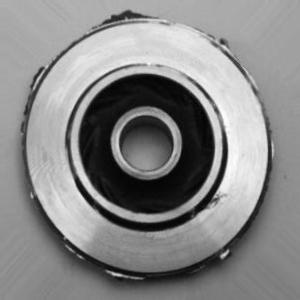

DEF


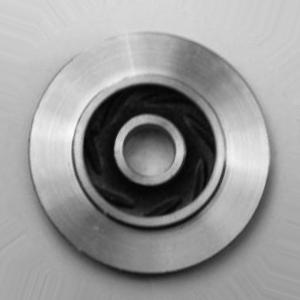

OK


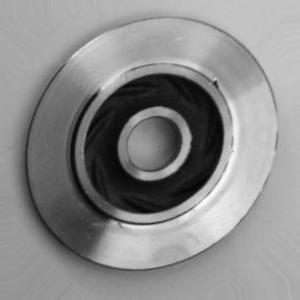

DEF


In [7]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))


In [8]:
label_names = ['ok', 'def']

label_to_index = dict((name, index) for index, name in enumerate(label_names))


In [9]:
label_to_index

{'ok': 0, 'def': 1}

In [10]:
def mk_idx(x):
    if 'ok' in x:
        return 'ok'
    else:
        return 'def'


In [11]:
all_image_labels = [label_to_index[mk_idx(path)] for path in all_image_paths]

In [12]:
for path in all_image_paths[:10]:
    print(mk_idx(path))

def
ok
ok
ok
def
def
def
def
ok
ok


In [13]:
all_image_labels[:10]

[1, 0, 0, 0, 1, 1, 1, 1, 0, 0]

In [14]:
img_path =all_image_paths[0]
img_path

'../input/train_data/cast_def_0_95.jpeg'

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [16]:
img_tensor = tf.image.decode_image(img_raw)


In [17]:
print(img_tensor.shape)
print(img_tensor.dtype)

(300, 300, 3)
<dtype: 'uint8'>


In [18]:
img_final = tf.image.resize(img_tensor, [192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.020542279
0.9989813


In [19]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192,192])
    image /= 255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'DEF')

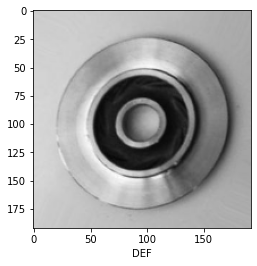

In [21]:
image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [23]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [24]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


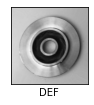

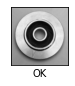

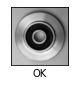

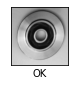

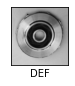

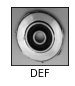

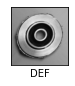

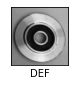

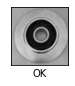

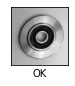

In [30]:
plt.figure(figsize=(8,8))

for n, image in enumerate(image_ds.take(10)):
    plt.subplot(2,5,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()


In [26]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))


In [28]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])


def
ok
ok
ok
def
def
def
def
ok
ok
